In [4]:
# 로깅 모듈: 프로그램 실행 중 발생하는 정보, 경고, 오류를 기록
import logging
# 시간 지연: 페이지 로딩 대기 등을 위한 시간 제어
import time
# 타입 힌팅: 함수의 매개변수와 반환값의 타입을 명시하여 코드 가독성 향상
from typing import Dict, List, Optional
# 데이터 구조 정의: 설정값을 묶어 전달하기 위해 dataclass 사용
from dataclasses import dataclass
# 타임스탬프 생성: 결과 파일명에 실행 시점을 명시하기 위해 사용
from datetime import datetime
# Jupyter 출력 제어: DataFrame 미리보기를 위해 display 함수 사용
from IPython.display import display

# 데이터 분석 및 처리: 크롤링한 데이터를 DataFrame으로 변환하고 CSV로 저장
import pandas as pd
# HTML 파싱: Selenium으로 가져온 HTML 소스를 파싱하여 원하는 데이터 추출
from bs4 import BeautifulSoup
# 웹 자동화: 동적으로 로드되는 웹페이지를 제어하기 위한 브라우저 자동화 도구
from selenium import webdriver
# Chrome 옵션 설정: headless 모드, User-Agent 등 브라우저 동작 제어
from selenium.webdriver.chrome.options import Options
# Chrome 드라이버 서비스: ChromeDriver 실행을 위한 서비스 설정
from selenium.webdriver.chrome.service import Service
# 요소 찾기: ID, 클래스명, CSS 선택자 등으로 웹 요소를 찾기 위한 메서드
from selenium.webdriver.common.by import By
# 대기 조건: 특정 요소가 나타날 때까지 기다리는 조건 설정
from selenium.webdriver.support import expected_conditions as EC
# 명시적 대기: 페이지 로딩이나 요소가 나타날 때까지 최대 시간 동안 대기
from selenium.webdriver.support.ui import WebDriverWait
# ChromeDriver 자동 관리: ChromeDriver를 자동으로 다운로드하고 버전 관리
from webdriver_manager.chrome import ChromeDriverManager



In [ ]:
def setup_logging(level: int = logging.INFO) -> None:
    """
    로그 포맷과 레벨을 설정합니다.
    
    Args:
        level: 로그 레벨 (기본값: INFO)
              - DEBUG: 상세한 디버깅 정보
              - INFO: 일반적인 정보 메시지
              - WARNING: 경고 메시지
              - ERROR: 오류 메시지
    """
    # 로깅 기본 설정: 시간, 로그 레벨, 메시지를 포함한 포맷 지정
    logging.basicConfig(
        level=level,  # 로그 레벨 설정
        format="%(asctime)s [%(levelname)s] %(message)s",  # 로그 포맷: 시간 [레벨] 메시지
        datefmt="%Y-%m-%d %H:%M:%S",  # 날짜/시간 포맷
    )


def create_webdriver(headless: bool = True) -> webdriver.Chrome:
    """
    Selenium Chrome WebDriver를 초기화합니다.
    
    Args:
        headless: True면 브라우저 창을 띄우지 않고 백그라운드에서 실행 (기본값: True)
    
    Returns:
        초기화된 Chrome WebDriver 객체
    """
    # Chrome 브라우저 옵션 객체 생성
    options = Options()
    
    # headless 모드: 브라우저 창을 띄우지 않고 백그라운드에서 실행 (서버 환경에 적합)
    if headless:
        options.add_argument("--headless=new")
    
    # GPU 가속 비활성화: 리소스 절약 및 안정성 향상
    options.add_argument("--disable-gpu")
    # 샌드박스 모드 비활성화: 일부 환경에서 실행 오류 방지
    options.add_argument("--no-sandbox")
    # 공유 메모리 사용 비활성화: Docker 등 제한된 환경에서 안정성 향상
    options.add_argument("--disable-dev-shm-usage")
    # 브라우저 창 크기 설정: 일부 사이트가 반응형으로 동작하므로 크기 지정 필요
    options.add_argument("--window-size=1920,1080")
    # User-Agent 설정: 실제 브라우저처럼 보이게 하여 봇 차단 회피
    options.add_argument(
        "--user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
        "AppleWebKit/537.36 (KHTML, like Gecko)"
        " Chrome/120.0.0.0 Safari/537.36"
    )

    # ChromeDriver 자동 설치 및 서비스 생성
    service = Service(ChromeDriverManager().install())
    # 설정된 옵션과 서비스로 Chrome WebDriver 생성 및 반환
    return webdriver.Chrome(service=service, options=options)


def clean_price(price_text: Optional[str]) -> Optional[int]:
    """
    가격 문자열에서 숫자만 추출해 정수로 반환합니다.
    
    예시: "₩129,000" -> 129000, "할인가 89,000원" -> 89000
    
    Args:
        price_text: 가격이 포함된 문자열 (예: "₩129,000", "89,000원")
    
    Returns:
        추출된 숫자를 정수로 변환한 값, 실패 시 None
    """
    # None 체크: 입력값이 없으면 None 반환
    if not price_text:
        return None
    
    # 문자열에서 숫자만 추출: "₩129,000" -> "129000"
    digits = "".join(ch for ch in price_text if ch.isdigit())
    
    # 추출된 숫자가 있으면 정수로 변환, 없으면 None 반환
    return int(digits) if digits else None


def parse_product(card) -> Optional[Dict[str, Optional[int]]]:
    """
    상품 카드(HTML 요소)에서 필요한 필드를 추출합니다.
    
    무신사 랭킹 페이지의 새로운 구조에서 다음 정보를 추출:
    - 브랜드명, 상품명, 정상가, 할인가, 할인율, 상품URL, 이미지URL
    
    Args:
        card: BeautifulSoup으로 파싱된 상품 카드 HTML 요소 (div.UIProductColumn__Wrap 또는 div.gtm-view-item-list)
    
    Returns:
        추출된 상품 정보를 담은 딕셔너리, 실패 시 None
    """
    try:
        # 방법 1: data 속성에서 직접 추출 (가장 안정적)
        data_price = card.get("data-price")
        data_original_price = card.get("data-original-price")
        data_discount_rate = card.get("data-discount-rate")
        data_item_brand = card.get("data-item-brand")
        
        # 상품 정보 영역 찾기 (클래스명 부분 매칭)
        info_item = card.select_one("div[class*='InfoItem']")
        if not info_item:
            # 대체 선택자: pl-3 pr-2 pt-3 pb-6 bg-white 클래스 조합
            info_item = card.select_one("div.pl-3.pr-2.pt-3.pb-6.bg-white")
        
        if not info_item:
            logging.warning("상품 정보 영역을 찾지 못했습니다. 카드 스킵")
            return None
        
        # 브랜드명 추출: a.gtm-click-brand 안의 p 태그
        brand_elem = info_item.select_one("a.gtm-click-brand p")
        if not brand_elem:
            # 대체 선택자: text-etc_11px_semibold 클래스가 있는 p 태그
            brand_elem = info_item.select_one("a.gtm-click-brand p[class*='text-etc_11px_semibold']")
        if not brand_elem:
            # 대체 방법: data 속성에서 브랜드명 가져오기
            brand_name = data_item_brand if data_item_brand else None
        else:       
            brand_name = brand_elem.text.strip()
        
        # 상품명 추출: a.gtm-select-item 안의 p 태그
        name_elem = info_item.select_one("a.gtm-select-item")
        if not name_elem:
            logging.warning("상품명 요소를 찾지 못했습니다. 카드 스킵")
            return None
        
        product_name = None
        # 상품명 p 태그 찾기 (클래스명 부분 매칭)
        name_p = name_elem.select_one("p[class*='text-body_13px_reg']")
        if not name_p:
            # 대체 선택자: line-clamp-2가 있는 p 태그
            name_p = name_elem.select_one("p[class*='line-clamp-2']")
        if name_p:
            product_name = name_p.text.strip()
        else:
            # 대체 방법: a 태그의 텍스트 직접 추출
            product_name = name_elem.text.strip()
        
        # 상품 URL 추출
        product_url = name_elem.get("href")
        if product_url and not product_url.startswith("http"):
            product_url = "https://www.musinsa.com" + product_url
        
        # 가격 정보 추출 (클래스명 부분 매칭)
        price_div = info_item.select_one("div[class*='Price']")
        
        # 정상가와 할인가: data 속성 우선, 없으면 텍스트에서 추출
        original_price = None
        sale_price = None
        discount_rate = None
        
        if data_original_price:
            original_price = int(data_original_price) if data_original_price.isdigit() else clean_price(data_original_price)
        if data_price:
            sale_price = int(data_price) if data_price.isdigit() else clean_price(data_price)
        if data_discount_rate:
            discount_rate = int(data_discount_rate) if data_discount_rate.isdigit() else None
        
        # data 속성에 없으면 텍스트에서 추출
        if price_div:
            price_spans = price_div.select("span[class*='PriceText']")
            for span in price_spans:
                text = span.text.strip()
                # 할인율: 빨간색 텍스트 (text-red 클래스 또는 숫자+% 패턴)
                if "%" in text or span.get("class") and "text-red" in " ".join(span.get("class", [])):
                    if not discount_rate:
                        digits = "".join(ch for ch in text if ch.isdigit())
                        discount_rate = int(digits) if digits else None
                # 가격: "원"으로 끝나는 텍스트
                elif "원" in text:
                    price_value = clean_price(text)
                    if price_value:
                        if not sale_price:
                            sale_price = price_value
                        elif not original_price:
                            original_price = price_value
        
        # 정상가가 없으면 할인가를 정상가로 설정
        if not original_price:
            original_price = sale_price
        
        # 이미지 URL 추출 (클래스명 부분 매칭)
        image_url = None
        img_wrap = card.select_one("div[class*='UIProductColumn__Wrap'][class*='jBRSiU']")
        if not img_wrap:
            # 대체 선택자: 이미지가 있는 div 찾기
            img_wrap = card.select_one("div[class*='UIProductColumn__Wrap']")
        if img_wrap:
            img_elem = img_wrap.select_one("img")
            if img_elem:
                image_url = img_elem.get("src") or img_elem.get("data-original")
                if image_url and not image_url.startswith("http"):
                    image_url = "https:" + image_url if image_url.startswith("//") else image_url
        
        # 필수 정보 검증
        if not (brand_name and product_name):
            logging.warning("필수 정보(브랜드명 또는 상품명)가 누락된 카드 발견. 카드 스킵")
            return None
        
        # 추출한 모든 정보를 딕셔너리로 반환
        return {
            "브랜드명": brand_name,
            "상품명": product_name,
            "정상가": original_price,
            "할인가": sale_price,
            "할인율(%)": discount_rate,
            "상품URL": product_url,
            "이미지URL": image_url,
        }
    
    except Exception as e:
        logging.warning("상품 정보 추출 중 오류 발생: %s", str(e))
        return None


def build_ranking_url(gender: str, age_band: str, period: str) -> str:
    """무신사 랭킹 페이지 URL을 생성합니다.

    Args:
        gender: 성별 코드 ("M" = 남성, "F" = 여성)
        age_band: 연령대 코드 (예: "AGE_BAND_20", "AGE_BAND_40")
        period: 기간 ("WEEKLY" 또는 "MONTHLY")

    Returns:
        완성된 URL 문자열
    """
    base_url = "https://www.musinsa.com/main/musinsa/ranking"
    params = {
        "gf": gender,  # 성별
        "storeCode": "musinsa",
        "sectionId": "199",  # 전체 카테고리 랭킹 섹션
        "contentsId": "",
        "categoryCode": "000",  # 전체 카테고리
        "ageBand": age_band,  # 연령대 필터
        "period": period,  # WEEKLY 또는 MONTHLY
        "subPan": "product",  # 상품 탭
    }

    # URL 쿼리 문자열 생성
    query_string = "&".join(f"{k}={v}" for k, v in params.items())
    return f"{base_url}?{query_string}"



def get_musinsa_ranking(url: str, limit: int = 30, wait_timeout: int = 30) -> List[Dict[str, Optional[int]]]:
    """
    무신사 랭킹 페이지에서 상위 limit개의 상품을 수집합니다.
    
    Selenium으로 동적 페이지를 로드하고, BeautifulSoup으로 HTML을 파싱하여
    상품 정보를 추출합니다.
    
    Args:
        url: 무신사 랭킹 페이지 URL (카테고리와 기간이 포함된 완전한 URL)
        limit: 수집할 상품 개수 (기본값: 30)
        wait_timeout: 페이지 로딩 대기 시간(초) (기본값: 30)
    
    Returns:
        상품 정보를 담은 딕셔너리 리스트
    """
    # WebDriver 생성: 브라우저 자동화를 위한 드라이버 초기화
    driver = create_webdriver()
    # 중복 제거를 위한 딕셔너리 (Key: 상품URL 또는 상품명)
    unique_products: Dict[str, Dict[str, Optional[int]]] = {}

    try:
        # 로그 기록: 접속할 URL 출력
        logging.info("페이지 접속: %s", url)
        # 지정된 URL로 브라우저 이동
        driver.get(url)
        
        # 페이지 로딩 대기
        time.sleep(3)
        
        # 초기 스크롤 및 로딩 대기
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)
        
        # 상품 카드 선택자 목록
        card_selectors_bs4 = [
            "div.gtm-view-item-list",  # 최신 구조
            "div.UIProductColumn__Wrap-sc-1t5ihy5-0",
            "div[class*='UIProductColumn__Wrap'][class*='gtm-view-item-list']",
            "div[data-item-id]",
            "li.li_box",
            "a.gtm-select-item[data-item-id]",
        ]

        last_height = driver.execute_script("return document.body.scrollHeight")
        max_scroll_rounds = 20  # 최대 스크롤 횟수 증가

        for scroll_round in range(max_scroll_rounds):
            # 현재 뷰 파싱
            soup = BeautifulSoup(driver.page_source, "html.parser")
            
            # 상품 카드 찾기
            cards = []
            for selector in card_selectors_bs4:
                found_cards = soup.select(selector)
                if not found_cards:
                    continue

                if selector.startswith("a.gtm-select-item"):
                    tmp_cards = []
                    for a_elem in found_cards:
                        parent = a_elem.find_parent("div", attrs={"data-item-id": True})
                        if not parent:
                            parent = a_elem.find_parent(
                                "div",
                                class_=lambda x: x and ("gtm-view-item-list" in str(x) or "UIProductColumn__Wrap" in str(x))
                            )
                        if parent and parent not in tmp_cards:
                            tmp_cards.append(parent)
                    cards = tmp_cards
                else:
                    cards = found_cards
                
                if cards:
                    break

            # 현재 라운드에서 발견된 상품 처리
            added_count = 0
            for card in cards:
                product = parse_product(card)
                if product:
                    # 고유 키 생성 (상품URL 우선, 없으면 상품명+브랜드명)
                    key = product.get("상품URL")
                    if not key:
                        key = f"{product.get('브랜드명')}_{product.get('상품명')}"
                    
                    if key and key not in unique_products:
                        unique_products[key] = product
                        added_count += 1
            
            logging.info("스크롤 %d회: %d개 신규 발견 (누적 %d/%d)", 
                         scroll_round, added_count, len(unique_products), limit)

            # 목표 달성 시 중단
            if len(unique_products) >= limit:
                logging.info("목표 수량 달성 완료")
                break

            # 스크롤 다운
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)
            
            # 스크롤 높이 변화 확인 (더 로드할 것이 없는지 체크)
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                # 높이 변화가 없으면 약간 위로 올렸다 다시 내려서 트리거 시도
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight - 300);")
                time.sleep(0.5)
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(1)
                
                new_height = driver.execute_script("return document.body.scrollHeight")
                if new_height == last_height:
                    logging.info("더 이상 스크롤할 수 없습니다 (페이지 끝 도달).")
                    break
            last_height = new_height

        if not unique_products:
            logging.error("상품을 하나도 찾지 못했습니다.")
            return []

        products = list(unique_products.values())
        logging.info("총 %d개의 상품 수집 완료", len(products))
        
        return products[:limit]

    except Exception as e:
        logging.error("크롤링 중 오류 발생: %s", str(e))
        logging.exception("상세 오류 정보:")
        return list(unique_products.values())

    finally:
        # 예외 발생 여부와 관계없이 항상 실행: 브라우저 종료
        driver.quit()
        logging.info("WebDriver 종료")


- **목표**: Fashion_Platform_Trend_Analysis 노트북의 크롤링·시각화 로직을 사람이 읽기 쉬운 구조로 정리한다.
- **지침**:
  1. 반복되는 상수와 출력 코드를 헬퍼 함수/데이터 구조로 추출한다.
  2. 데이터 수집 → 저장 → 보고 단계를 각각 독립 함수로 분리한다.
  3. 모든 함수는 단일 책임을 갖도록 하고, 실행 흐름은 진입점에서 순차적으로 호출한다.
  4. 시각화 전역 설정(폰트, 스타일 등)은 한 곳에서 정의하고 각 셀에서는 그래프 로직만 남긴다.
  5. 사용자 메시지와 로그는 전용 함수로 감싸 일관된 형식을 유지한다.



In [6]:
# 로깅 설정 초기화: 프로그램 실행 중 발생하는 로그를 출력하도록 설정
setup_logging()

# ============================================
# 크롤링 범위 설정
# ============================================

# 기간 정의: 1주(주간), 1개월(월간)
PERIODS = {
    "1주": "WEEKLY",
    "1개월": "MONTHLY",
}

# 성별 정의 (남/여)
GENDERS = {
    "남성": "M",
    "여성": "F",
}

# 연령대 정의
AGE_BANDS = {
    "19세이하": "AGE_BAND_MINOR",
    "20-24세": "AGE_BAND_20",
    "25-29세": "AGE_BAND_25",
    "30-34세": "AGE_BAND_30",
    "35-39세": "AGE_BAND_35",
    "40세이상": "AGE_BAND_40",
}

# 크롤링 설정
LIMIT_PER_CATEGORY = 100  # 성별 × 연령대 × 기간 조합당 수집할 상품 개수
REQUEST_INTERVAL_SECONDS = 2  # 서버 부하 방지를 위한 요청 간 대기


@dataclass(frozen=True)
class CrawlConfig:
    genders: Dict[str, str]
    age_bands: Dict[str, str]
    periods: Dict[str, str]
    limit_per_combination: int

    @property
    def total_combinations(self) -> int:
        return len(self.genders) * len(self.age_bands) * len(self.periods)

    @property
    def expected_items(self) -> int:
        return self.total_combinations * self.limit_per_combination


def summarize_crawl_scope(config: CrawlConfig) -> None:
    """현재 크롤링 범위를 사람 눈으로 한 번에 이해하기 쉽게 출력합니다."""
    divider = "=" * 80
    print(divider)
    print("📋 크롤링 범위 설정")
    print(divider)

    print(f"\n👤 성별: {len(config.genders)}개")
    for gender_name, gender_code in config.genders.items():
        print(f"   - {gender_name} (코드: {gender_code})")

    print(f"\n🧑‍🦱 연령대: {len(config.age_bands)}개")
    for age_name, age_code in config.age_bands.items():
        print(f"   - {age_name} (코드: {age_code})")

    print(f"\n📅 기간: {len(config.periods)}개")
    for period_name, period_code in config.periods.items():
        print(f"   - {period_name} ({period_code})")

    print("\n📊 수집 설정:")
    print(f"   - 조합당 수집 개수: {config.limit_per_combination}개")
    print(f"   - 총 조합 수: {config.total_combinations}개")
    print(f"   - 예상 총 데이터: {config.expected_items}개")
    print(divider)


def iter_crawl_combinations(config: CrawlConfig):
    """성별 × 연령대 × 기간 조합을 순회하는 제너레이터.

    사람이 읽기 쉽게 (성별 이름, 연령대 이름, 기간 이름)을 그대로 넘기고,
    URL 생성에는 대응되는 코드 값을 함께 넘겨줍니다.
    """
    for gender_name, gender_code in config.genders.items():
        for age_name, age_code in config.age_bands.items():
            for period_name, period_code in config.periods.items():
                yield (
                    gender_name,
                    gender_code,
                    age_name,
                    age_code,
                    period_name,
                    period_code,
                )


def collect_ranking_data(config: CrawlConfig) -> pd.DataFrame:
    """설정된 성별 × 연령대 × 기간 조합에 대해 랭킹 데이터를 수집합니다."""
    results: List[Dict[str, Optional[int]]] = []

    logging.info("=" * 80)
    logging.info("크롤링 시작")
    logging.info("총 성별: %d개", len(config.genders))
    logging.info("총 연령대: %d개", len(config.age_bands))
    logging.info("총 기간: %d개", len(config.periods))
    logging.info("총 조합: %d개", config.total_combinations)
    logging.info("=" * 80)

    for idx, (
        gender_name,
        gender_code,
        age_name,
        age_code,
        period_name,
        period_code,
    ) in enumerate(iter_crawl_combinations(config), start=1):
        logging.info("")
        logging.info("-" * 80)
        logging.info(
            "[%d/%d] 성별: %s | 연령대: %s | 기간: %s",
            idx,
            config.total_combinations,
            gender_name,
            age_name,
            period_name,
        )
        logging.info("-" * 80)

        url = build_ranking_url(gender_code, age_code, period_code)

        try:
            products = get_musinsa_ranking(url, limit=config.limit_per_combination)
        except Exception as exc:
            logging.error(
                "❌ 크롤링 실패: 성별=%s, 연령대=%s, 기간=%s",
                gender_name,
                age_name,
                period_name,
                exc_info=exc,
            )
            continue

        for product in products:
            product["성별"] = gender_name
            product["연령대"] = age_name
            product["기간"] = period_name
            # sectionId=199, categoryCode=000 기준으로 카테고리는 전체로 고정
            product["카테고리"] = "전체"
            results.append(product)

        logging.info("✅ 수집 완료: %d개 상품", len(products))
        time.sleep(REQUEST_INTERVAL_SECONDS)

    return pd.DataFrame(results)


def reorder_columns(df: pd.DataFrame) -> pd.DataFrame:
    """분석과 사람이 읽기에 편한 컬럼 순서로 정렬합니다."""
    column_order = [
        "성별",
        "연령대",
        "기간",
        "카테고리",
        "브랜드명",
        "상품명",
        "정상가",
        "할인가",
        "할인율(%)",
        "상품URL",
        "이미지URL",
    ]
    existing_columns = [col for col in column_order if col in df.columns]
    return df[existing_columns + [col for col in df.columns if col not in existing_columns]]


def persist_results(df: pd.DataFrame, prefix: str = "musinsa_ranking") -> str:
    """수집된 데이터를 타임스탬프가 포함된 CSV 파일로 저장합니다."""
    filename = f"{prefix}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    df.to_csv(filename, index=False, encoding="utf-8-sig")
    return filename


def report_crawl_summary(df: pd.DataFrame, output_path: str) -> None:
    """크롤링 요약 정보를 로그와 콘솔로 출력합니다."""
    logging.info("")
    logging.info("=" * 80)
    logging.info("✅ 전체 크롤링 완료!")
    logging.info("CSV 저장 완료: %s", output_path)
    logging.info("저장된 총 데이터 개수: %d개", len(df))
    logging.info("=" * 80)

    print("\n📊 성별 × 연령대 × 기간별 수집 통계:")
    stats = df.groupby(["성별", "연령대", "기간"]).size().reset_index(name="개수")
    print(stats.to_string(index=False))

    print("\n📋 수집된 데이터 미리보기 (상위 10개):")
    display(df.head(10))

    print(f"\n✅ 크롤링 및 CSV 저장이 완료되었습니다!")
    print(f"📁 파일 위치: {output_path}")
    print(f"📊 총 {len(df)}개의 상품 정보가 저장되었습니다.")


CRAWL_CONFIG = CrawlConfig(
    genders=GENDERS,
    age_bands=AGE_BANDS,
    periods=PERIODS,
    limit_per_combination=LIMIT_PER_CATEGORY,
)

summarize_crawl_scope(CRAWL_CONFIG)
ranking_df = collect_ranking_data(CRAWL_CONFIG)
LATEST_CSV_FILENAME: Optional[str] = None

if ranking_df.empty:
    logging.warning("수집된 데이터가 없습니다.")
else:
    ranking_df = reorder_columns(ranking_df)
    LATEST_CSV_FILENAME = persist_results(ranking_df)
    report_crawl_summary(ranking_df, LATEST_CSV_FILENAME)


2025-12-01 16:08:27 [INFO] ================================================================================
2025-12-01 16:08:27 [INFO] 크롤링 시작
2025-12-01 16:08:27 [INFO] 총 성별: 2개
2025-12-01 16:08:27 [INFO] 총 연령대: 6개
2025-12-01 16:08:27 [INFO] 총 기간: 2개
2025-12-01 16:08:27 [INFO] 총 조합: 24개
2025-12-01 16:08:27 [INFO] ================================================================================
2025-12-01 16:08:27 [INFO] 
2025-12-01 16:08:27 [INFO] --------------------------------------------------------------------------------
2025-12-01 16:08:27 [INFO] [1/24] 성별: 남성 | 연령대: 19세이하 | 기간: 1주
2025-12-01 16:08:27 [INFO] --------------------------------------------------------------------------------
2025-12-01 16:08:27 [INFO] ====== WebDriver manager ======


📋 크롤링 범위 설정

👤 성별: 2개
   - 남성 (코드: M)
   - 여성 (코드: F)

🧑‍🦱 연령대: 6개
   - 19세이하 (코드: AGE_BAND_MINOR)
   - 20-24세 (코드: AGE_BAND_20)
   - 25-29세 (코드: AGE_BAND_25)
   - 30-34세 (코드: AGE_BAND_30)
   - 35-39세 (코드: AGE_BAND_35)
   - 40세이상 (코드: AGE_BAND_40)

📅 기간: 2개
   - 1주 (WEEKLY)
   - 1개월 (MONTHLY)

📊 수집 설정:
   - 조합당 수집 개수: 100개
   - 총 조합 수: 24개
   - 예상 총 데이터: 2400개


2025-12-01 16:08:27 [INFO] Get LATEST chromedriver version for google-chrome
2025-12-01 16:08:27 [INFO] Get LATEST chromedriver version for google-chrome
2025-12-01 16:08:27 [INFO] Driver [/Users/parkjto/.wdm/drivers/chromedriver/mac64/142.0.7444.175/chromedriver-mac-arm64/chromedriver] found in cache
2025-12-01 16:08:28 [INFO] 페이지 접속: https://www.musinsa.com/main/musinsa/ranking?gf=M&storeCode=musinsa&sectionId=199&contentsId=&categoryCode=000&ageBand=AGE_BAND_MINOR&period=WEEKLY&subPan=product
2025-12-01 16:08:36 [INFO] 스크롤 0회: 36개 신규 발견 (누적 36/100)
2025-12-01 16:08:38 [INFO] 스크롤 1회: 36개 신규 발견 (누적 72/100)
2025-12-01 16:08:40 [INFO] 스크롤 2회: 36개 신규 발견 (누적 108/100)
2025-12-01 16:08:40 [INFO] 목표 수량 달성 완료
2025-12-01 16:08:40 [INFO] 총 108개의 상품 수집 완료
2025-12-01 16:08:40 [INFO] WebDriver 종료
2025-12-01 16:08:40 [INFO] ✅ 수집 완료: 100개 상품
2025-12-01 16:08:42 [INFO] 
2025-12-01 16:08:42 [INFO] --------------------------------------------------------------------------------
2025-12-01 16:08:42 [INF


📊 성별 × 연령대 × 기간별 수집 통계:
성별    연령대  기간  개수
남성  19세이하 1개월 100
남성  19세이하  1주 100
남성 20-24세 1개월 100
남성 20-24세  1주 100
남성 25-29세 1개월 100
남성 25-29세  1주 100
남성 30-34세 1개월 100
남성 30-34세  1주 100
남성 35-39세 1개월 100
남성 35-39세  1주 100
남성  40세이상 1개월 100
남성  40세이상  1주 100
여성  19세이하 1개월 100
여성  19세이하  1주 100
여성 20-24세 1개월 100
여성 20-24세  1주 100
여성 25-29세 1개월 100
여성 25-29세  1주 100
여성 30-34세 1개월 100
여성 30-34세  1주 100
여성 35-39세 1개월 100
여성 35-39세  1주 100
여성  40세이상 1개월 100
여성  40세이상  1주 100

📋 수집된 데이터 미리보기 (상위 10개):


,성별,연령대,기간,카테고리,브랜드명,상품명,정상가,할인가,할인율(%),상품URL,이미지URL
0,남성,19세이하,1주,전체,드로우핏,[패션플래닛X드로우핏] 워시드 크롭 옥스퍼드 셔츠 [5color],55000,49500,10,https://www.musinsa.com/products/5275916,https://image.msscdn.net/thumbnails/images/goo...
1,남성,19세이하,1주,전체,스웨이드,CONTOUR POCKET DENIM [WHITE],72000,64800,10,https://www.musinsa.com/products/5064188,https://image.msscdn.net/thumbnails/images/goo...
2,남성,19세이하,1주,전체,더마일,MILE GARMENTS SWEAT MTM [BLACK],64000,36900,42,https://www.musinsa.com/products/3578496,https://image.msscdn.net/thumbnails/images/goo...
3,남성,19세이하,1주,전체,밀로 아카이브,크롭 무브 가디건 [네이비],108000,86400,20,https://www.musinsa.com/products/4419823,https://image.msscdn.net/thumbnails/images/goo...
4,남성,19세이하,1주,전체,무신사 스탠다드,베이식 옥스포드 셔츠 [화이트],33900,32290,5,https://www.musinsa.com/products/728000,https://image.msscdn.net/thumbnails/images/goo...
5,남성,19세이하,1주,전체,1989스탠다드,BASIC LOGO 후드 (STHSTD-0006),66500,26990,59,https://www.musinsa.com/products/2990504,https://image.msscdn.net/thumbnails/images/goo...
6,남성,19세이하,1주,전체,가까이 유니언즈,원턱 투 라인 와이드 스웨트팬츠 블랙,50000,37500,25,https://www.musinsa.com/products/4343527,https://image.msscdn.net/thumbnails/images/goo...
7,남성,19세이하,1주,전체,트릴리온,헤어리 그래픽 로고 오버핏 자카드 니트 (BLUE),52000,39800,23,https://www.musinsa.com/products/4328686,https://image.msscdn.net/thumbnails/images/goo...
8,남성,19세이하,1주,전체,르아르,에센셜 후디드 라이트 패딩 자켓 (8color),142000,79900,44,https://www.musinsa.com/products/5479465,https://image.msscdn.net/thumbnails/images/goo...
9,남성,19세이하,1주,전체,스켈리웩,[폴라폴리스추가]라인 트레이닝 팬츠[그레이],59000,29990,49,https://www.musinsa.com/products/4556433,https://image.msscdn.net/thumbnails/images/goo...



✅ 크롤링 및 CSV 저장이 완료되었습니다!
📁 파일 위치: musinsa_ranking_20251201_161423.csv
📊 총 2400개의 상품 정보가 저장되었습니다.


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import platform

# 1. Seaborn 스타일 설정 (폰트 설정보다 먼저 해야 함)
sns.set_style("whitegrid")
sns.set_context("talk") # 글씨 크기를 키워 가독성 향상

# 2. 한글 폰트 설정
system_name = platform.system()
if system_name == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
elif system_name == 'Windows': # Windows
    plt.rc('font', family='Malgun Gothic')
else: # Linux
    # 나눔고딕이 설치되어 있는지 확인 후 설정
    fonts = [f.name for f in fm.fontManager.ttflist]
    if 'NanumGothic' in fonts:
        plt.rc('font', family='NanumGothic')
    else:
        # Fallback: 설치된 한글 폰트 중 하나 선택 시도 (예시)
        plt.rc('font', family='sans-serif') 

# 3. 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 4. 해상도 설정 (Retina 디스플레이 지원)
%config InlineBackend.figure_format = 'retina'

print(f"✅ 시각화 환경 설정 완료 (OS: {system_name})")

✅ 시각화 환경 설정 완료 (OS: Darwin)


In [11]:
# 데이터 로드
csv_file = "musinsa_ranking_20251201_161423.csv"
try:
    df = pd.read_csv(csv_file, encoding='utf-8-sig')
except FileNotFoundError:
    print(f"❌ 파일을 찾을 수 없습니다: {csv_file}")
    # 빈 데이터프레임 생성 (에러 방지용)
    df = pd.DataFrame(columns=['성별', '연령대', '기간', '정상가', '할인가', '할인율(%)'])

# 전처리: 가격 및 할인율 숫자 변환
def clean_currency(x):
    if isinstance(x, str):
        return int(x.replace(',', '').replace('원', ''))
    return x

if not df.empty:
    df['정상가'] = df['정상가'].apply(clean_currency)
    df['할인가'] = df['할인가'].apply(clean_currency)
    df['할인율(%)'] = df['할인율(%)'].fillna(0).astype(int)

    # 순위(Rank) 데이터 생성
    # 그룹별(성별, 연령대, 기간)로 순서대로 랭킹이 매겨져 있다고 가정
    df['순위'] = df.groupby(['성별', '연령대', '기간']).cumcount() + 1

    # 순위 구간 생성 (1-10위, 11-20위 ...)
    def get_rank_group(rank):
        start = ((rank-1)//10) * 10 + 1
        end = start + 9
        return f"{start}~{end}위"

    df['순위구간'] = df['순위'].apply(get_rank_group)
    
    # 순위 구간 정렬 순서 정의
    rank_groups_order = [f"{i*10+1}~{i*10+10}위" for i in range(10)]

    print(f"✅ 데이터 로드 및 전처리 완료 (총 {len(df)}개 상품)")
    display(df[['순위', '순위구간', '상품명', '할인율(%)']].head())
else:
    print("데이터가 없습니다.")

✅ 데이터 로드 및 전처리 완료 (총 2400개 상품)


,순위,순위구간,상품명,할인율(%)
0,1,1~10위,[패션플래닛X드로우핏] 워시드 크롭 옥스퍼드 셔츠 [5color],10
1,2,1~10위,CONTOUR POCKET DENIM [WHITE],10
2,3,1~10위,MILE GARMENTS SWEAT MTM [BLACK],42
3,4,1~10위,크롭 무브 가디건 [네이비],20
4,5,1~10위,베이식 옥스포드 셔츠 [화이트],5


### 1. 정상가 vs 할인가 (Original vs Discounted Price)
- 점의 색상이 **'할인율'**을 나타냅니다.
- **붉은 점선(y=x)**은 할인이 전혀 없는 경우를 의미합니다.
- 점선에서 아래로 멀어질수록 할인율이 높은 '득템' 상품입니다.

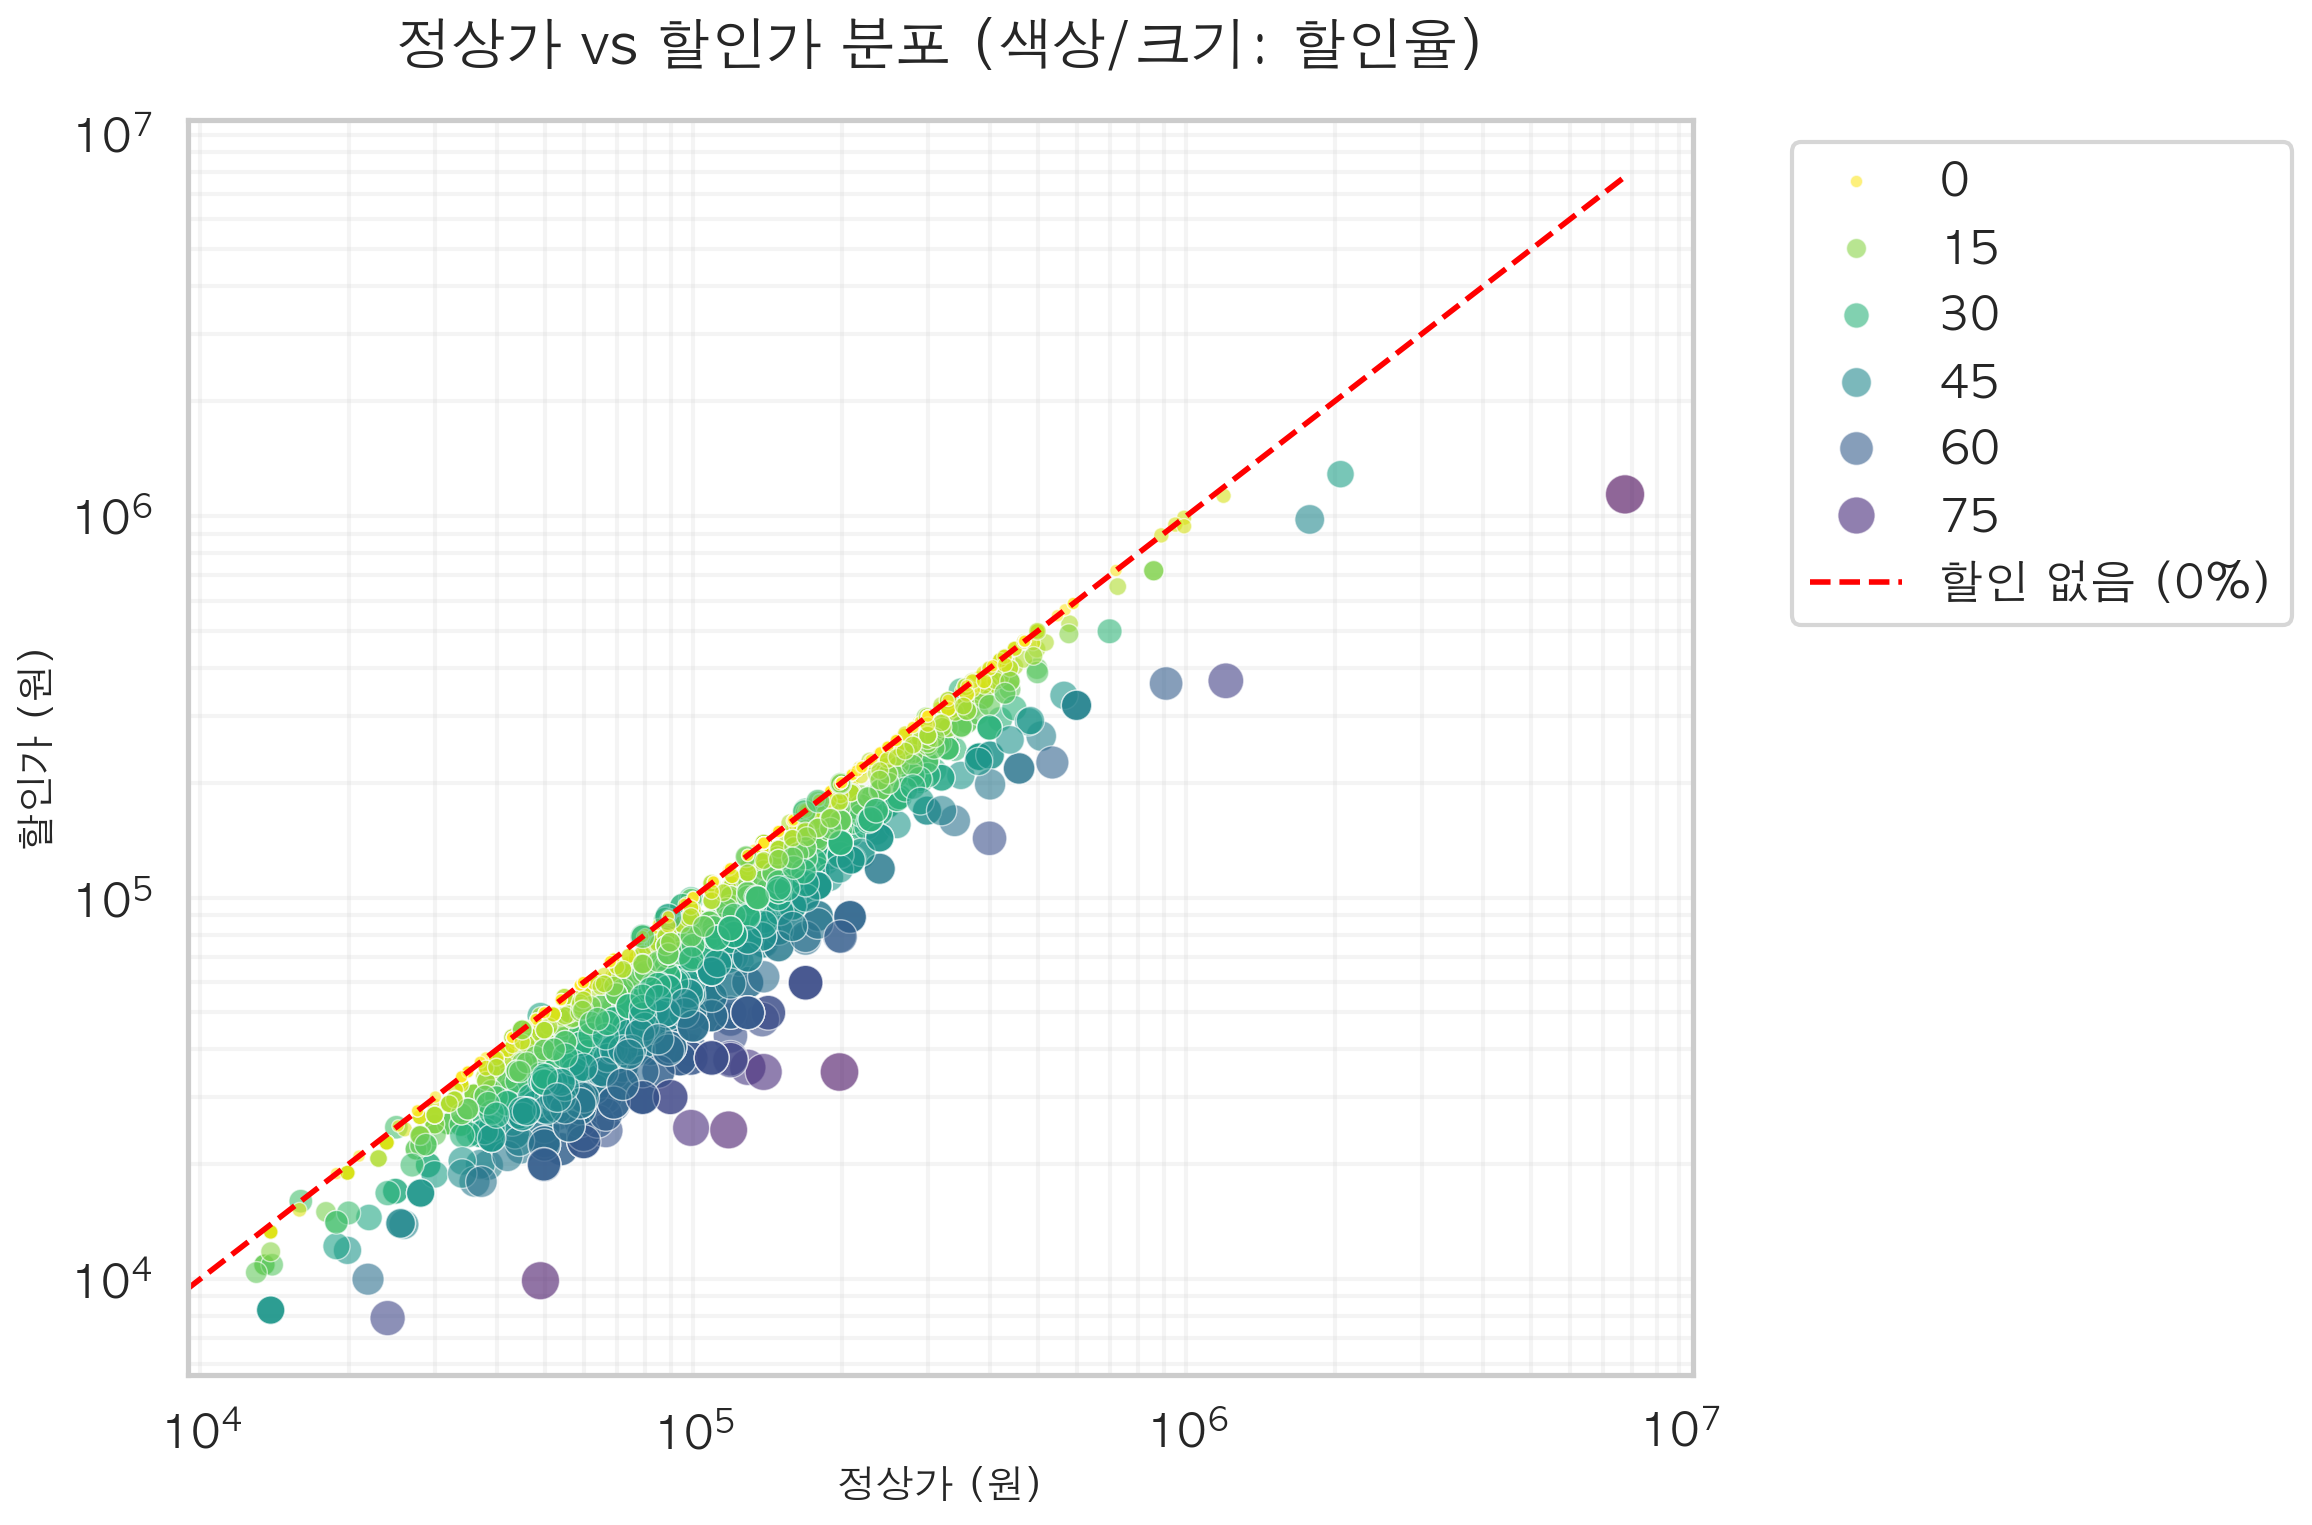

In [12]:
plt.figure(figsize=(12, 8))

# 산점도 그리기
scatter = sns.scatterplot(
    data=df, 
    x='정상가', 
    y='할인가', 
    hue='할인율(%)', 
    palette='viridis_r', # 반전된 viridis (노란색이 높은 할인율)
    size='할인율(%)',
    sizes=(20, 200),
    alpha=0.6,
    edgecolor='w',
    linewidth=0.5
)

# 기준선 (할인 없음)
max_val = df[['정상가', '할인가']].max().max()
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='할인 없음 (0%)')

# 디자인 개선
plt.title('정상가 vs 할인가 분포 (색상/크기: 할인율)', fontsize=20, pad=20)
plt.xlabel('정상가 (원)', fontsize=14)
plt.ylabel('할인가 (원)', fontsize=14)
plt.xscale('log') # 로그 스케일로 넓은 가격대 커버
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### 2. 순위 구간별 평균 할인율 (Avg Discount Rate by Rank)
- 상위권(1~10위)과 하위권의 평균 할인율 차이를 확인합니다.
- **상위권일수록 할인율이 높은지** 경향을 파악할 수 있습니다.

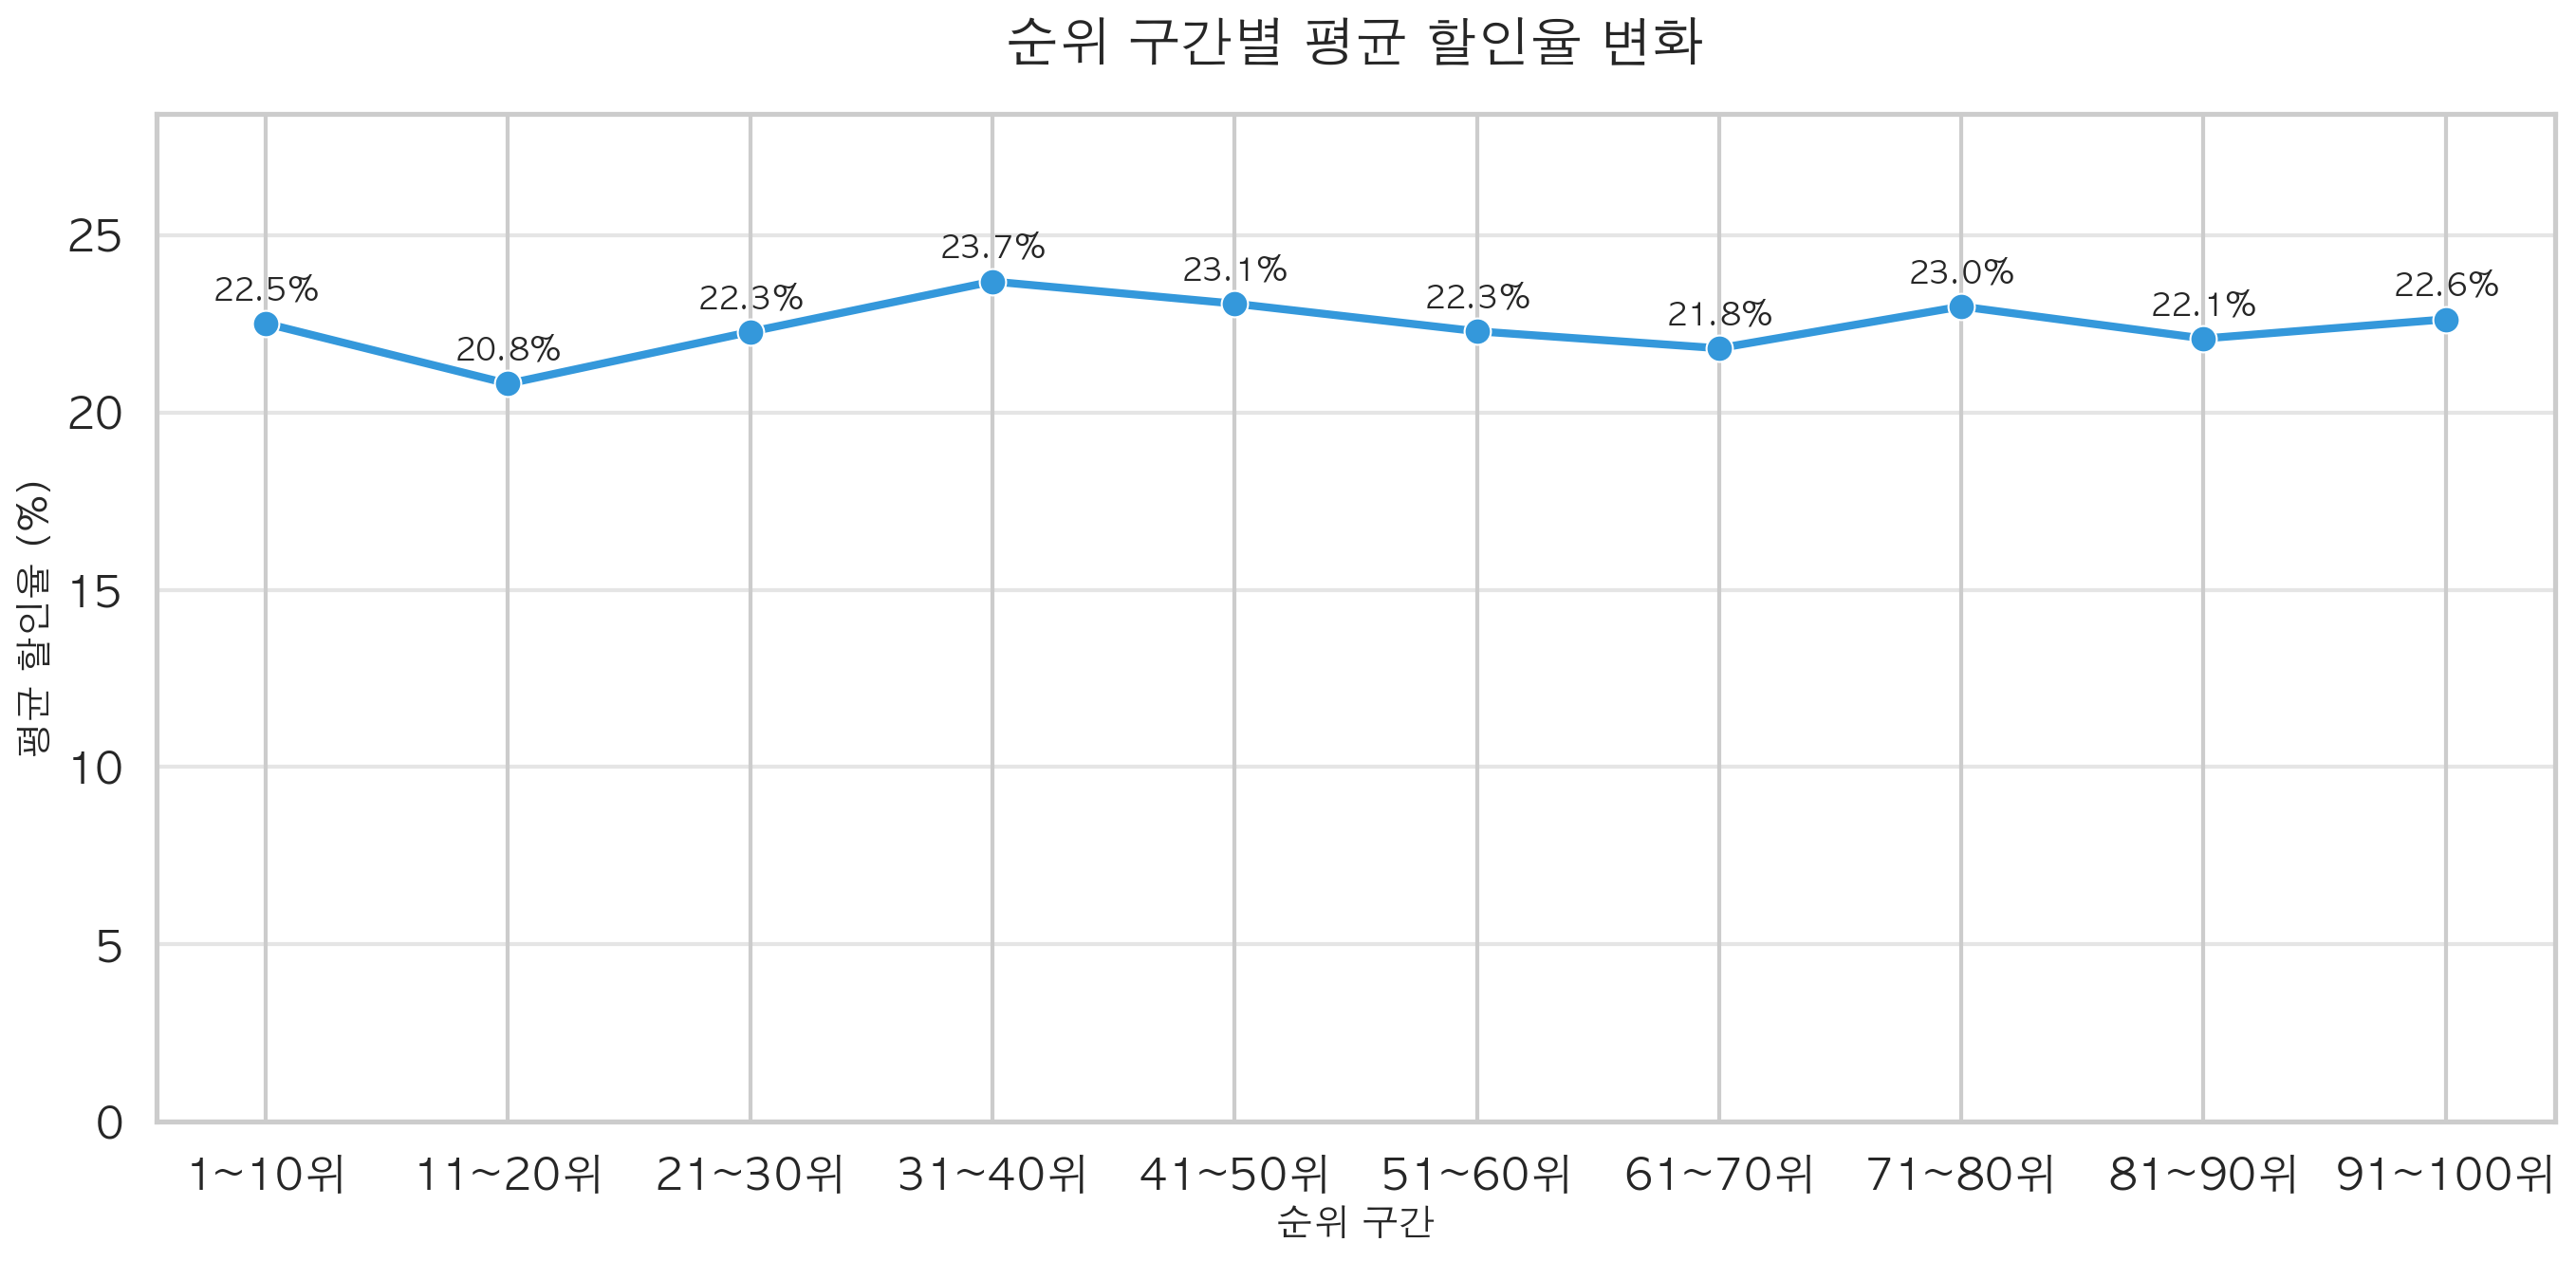

In [14]:
# 데이터 집계
avg_discount = df.groupby('순위구간')['할인율(%)'].mean().reindex(rank_groups_order)

plt.figure(figsize=(14, 7))

# 선 그래프
sns.lineplot(
    x=avg_discount.index, 
    y=avg_discount.values, 
    marker='o', 
    markersize=10,
    color='#3498db', 
    linewidth=3
)

# 값 레이블 추가
for i, v in enumerate(avg_discount.values):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')

# 디자인 개선
plt.title('순위 구간별 평균 할인율 변화', fontsize=20, pad=20)
plt.xlabel('순위 구간', fontsize=14)
plt.ylabel('평균 할인율 (%)', fontsize=14)
plt.xticks(rotation=0)
plt.ylim(0, max(avg_discount.values) * 1.2) # 위쪽 여백 확보
plt.grid(True, axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

### 3. 순위 구간별 평균 판매가 (Avg Price by Rank)
- 상위권 상품들이 고가인지 저가인지 **가격대 트렌드**를 보여줍니다.

/var/folders/72/p2cw62851vz5s_g2dbp_8ykm0000gn/T/ipykernel_24163/3647986875.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


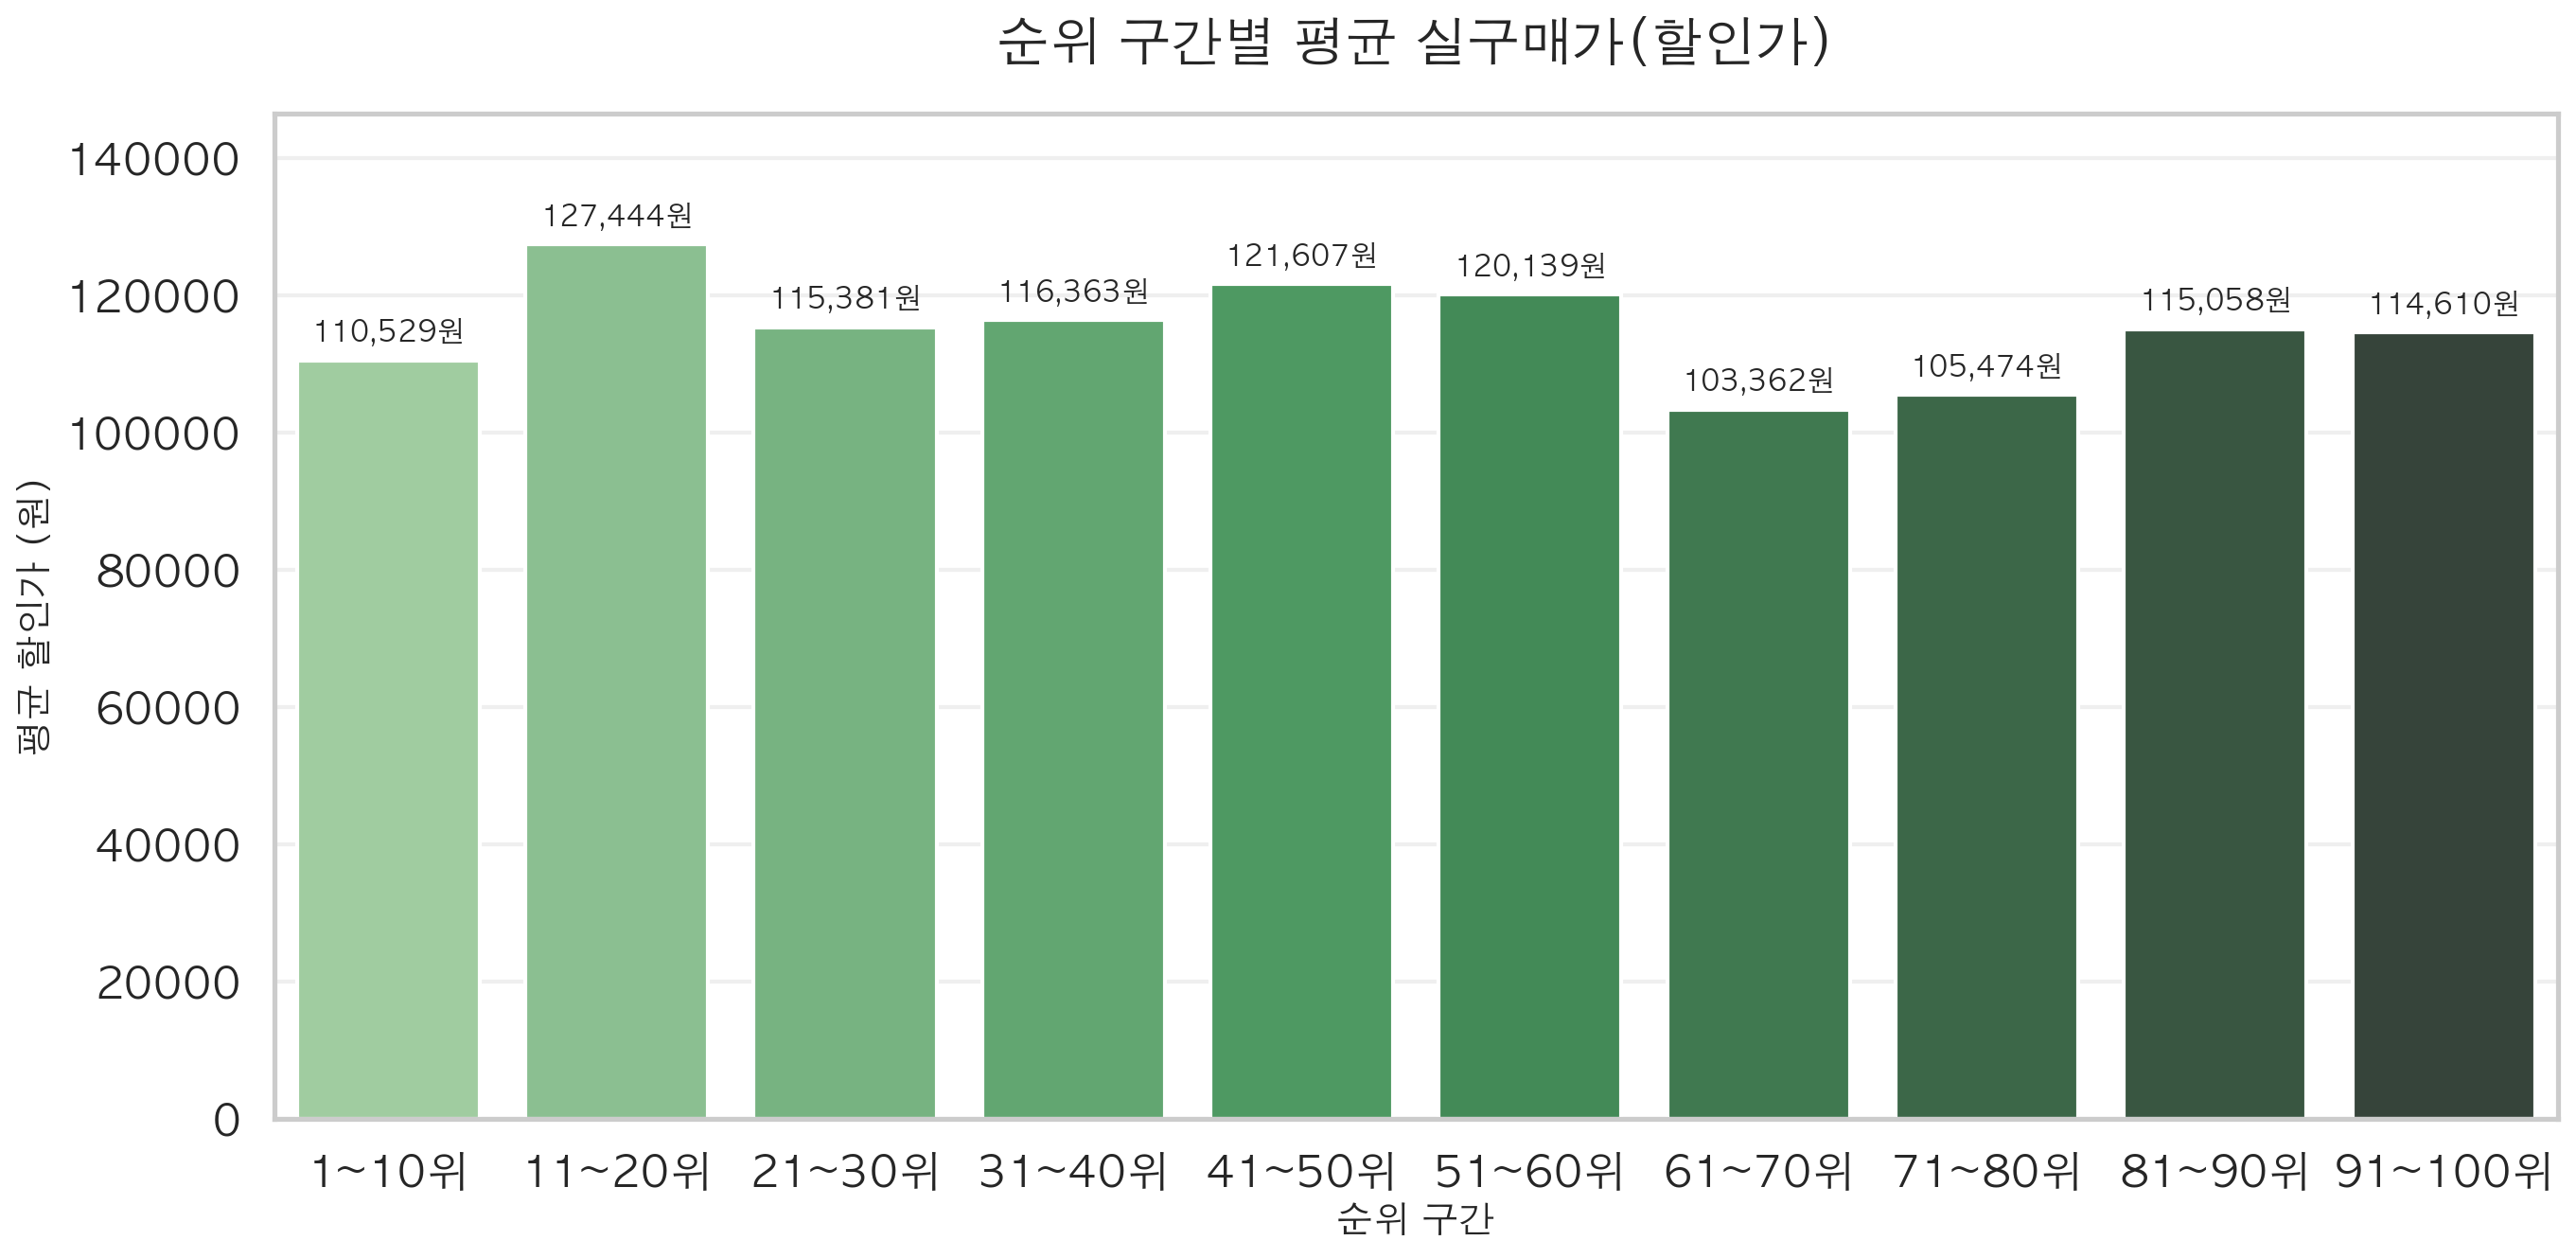

In [15]:
# 데이터 집계
avg_price = df.groupby('순위구간')['할인가'].mean().reindex(rank_groups_order)

plt.figure(figsize=(14, 7))

# 막대 그래프
barplot = sns.barplot(
    x=avg_price.index, 
    y=avg_price.values, 
    palette='Greens_d'
)

# 값 레이블 추가 (천 단위 콤마)
for i, v in enumerate(avg_price.values):
    plt.text(i, v + 2000, f"{int(v):,}원", ha='center', va='bottom', fontsize=11)

# 디자인 개선
plt.title('순위 구간별 평균 실구매가(할인가)', fontsize=20, pad=20)
plt.xlabel('순위 구간', fontsize=14)
plt.ylabel('평균 할인가 (원)', fontsize=14)
plt.xticks(rotation=0)
plt.ylim(0, max(avg_price.values) * 1.15)
plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 4. 순위와 할인율의 상관관계 (Rank vs Discount Rate)
- 전체 상품의 분포(회색 점)와 전체적인 경향성(붉은 선)을 확인합니다.
- **추세선이 우하향**한다면 상위권(순위 숫자가 작음)일수록 할인율이 높다는 의미입니다.

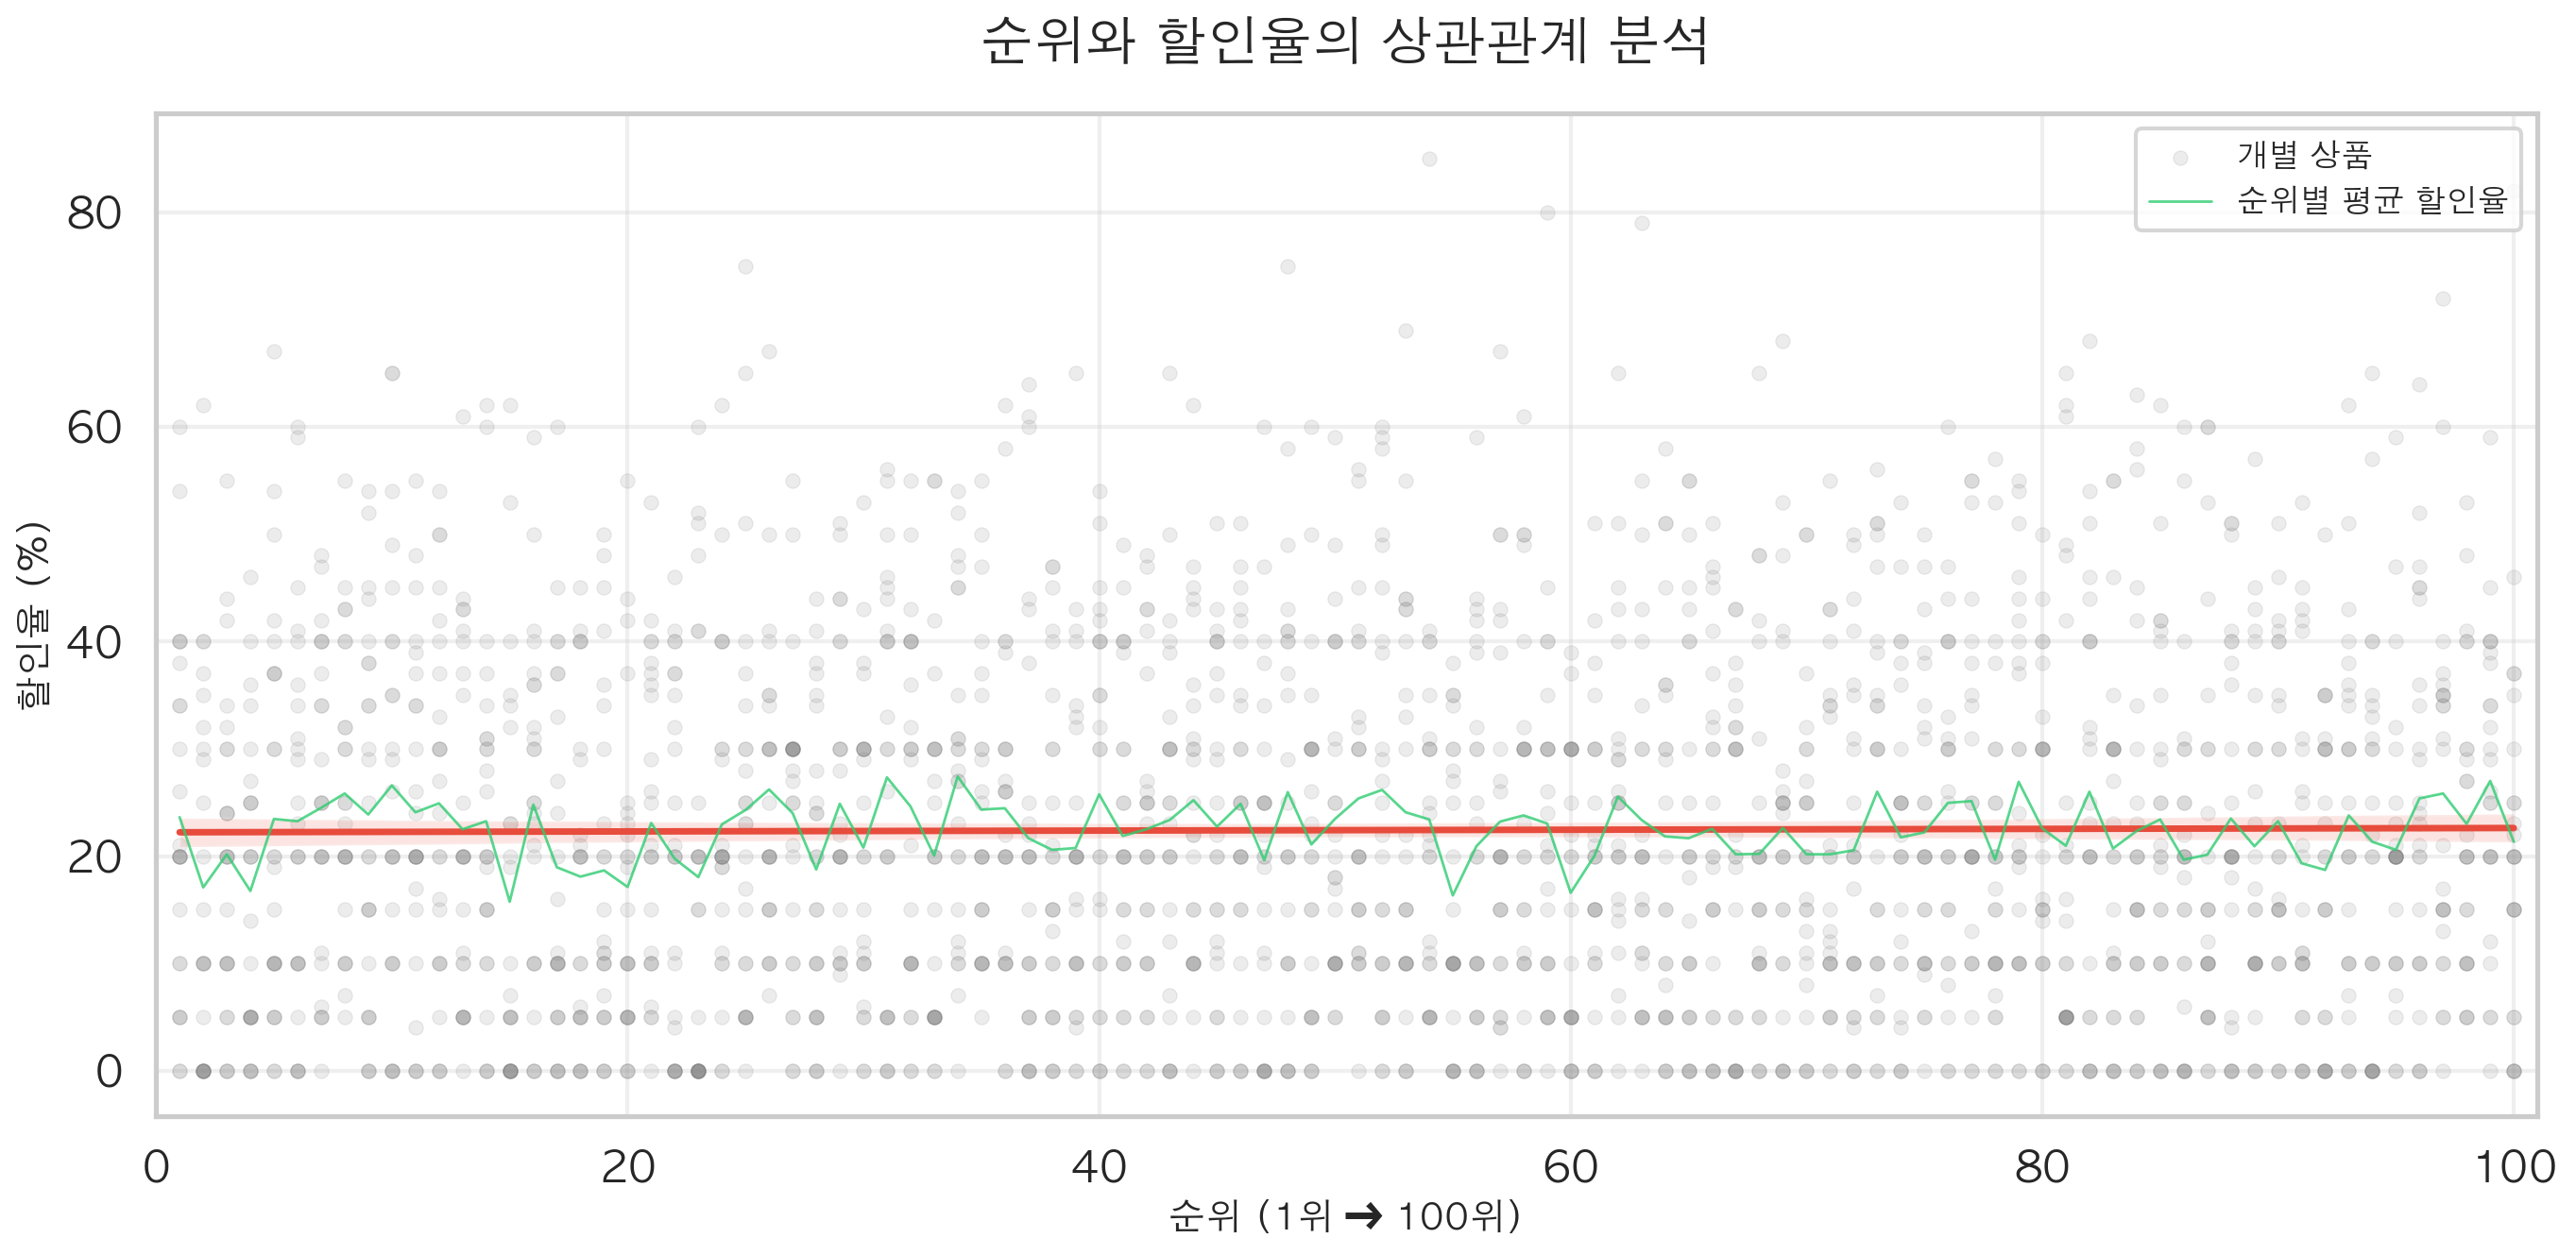

In [16]:
plt.figure(figsize=(14, 7))

# 1. 배경 산점도 (전체 분포 확인용)
sns.scatterplot(
    data=df, 
    x='순위', 
    y='할인율(%)', 
    alpha=0.15, 
    color='gray', 
    s=30,
    edgecolor=None,
    label='개별 상품'
)

# 2. 추세선 (경향성 파악)
sns.regplot(
    data=df, 
    x='순위', 
    y='할인율(%)', 
    scatter=False, 
    color='#e74c3c', 
    line_kws={'linewidth': 2.5, 'label': '추세선 (Linear Trend)'}
)

# 3. 구간별 평균점 (추세 확인 보조)
mean_by_rank = df.groupby('순위')['할인율(%)'].mean().reset_index()
sns.lineplot(
    data=mean_by_rank,
    x='순위',
    y='할인율(%)',
    color='#2ecc71',
    alpha=0.8,
    linewidth=1,
    label='순위별 평균 할인율'
)

# 디자인 개선
plt.title('순위와 할인율의 상관관계 분석', fontsize=20, pad=20)
plt.xlabel('순위 (1위 ➔ 100위)', fontsize=14)
plt.ylabel('할인율 (%)', fontsize=14)
plt.xlim(0, 101)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()